In [1]:
import glob, sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
#import tensorflow as tf
import re
import os
import glob
#from PrepareData import PrepareData
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
#from PrepareData import PrepareData
import math
import seaborn as sns
import json
sns.set()
#from important_functions import *
dat_size = 16777216
time_res = 64e-6 # in seconds
T_obs = (dat_size*time_res)/60 # in minutes is equal to 17.895 minutes
freq_axis = np.fft.rfftfreq(dat_size, d=64e-6)
freq_res = 1/(T_obs*60)

In [2]:
run = 'runBD'
labels_df = pd.read_csv(f'meta_data/labels_{run}.csv')

#Create a histogram with 100 bins
uniZ = labels_df_fil
data = uniZ['bper']
counts, bins = np.histogram(data, bins=100)

#Initialize an empty list to hold the results
sample = []

#We'll try to take 5 samples from each bin
samples_per_bin = 2000

#Loop over the bins
for i in range(len(bins)-1):
    # Get all values that are within the current bin
    bin_data = uniZ[(data >= bins[i]) & (data < bins[i+1])]['# ind']
    
    # Check if we have enough data in the current bin
    if bin_data.size >= samples_per_bin:
        # Randomly select 'samples_per_bin' elements
        #bin_data_period = uniZ.loc[bin_data]['period'].values
        #bin_data_period_sorted = np.argsort(bin_data_period)[-samples_per_bin:]
        bin_sample = np.random.choice(bin_data, size=samples_per_bin, replace=False)
        #bin_sample = bin_data.values[bin_data_period_sorted]
        #in_sample = np.append(bin_sample,bin_data.values[np.argsort(bin_data_period)[:10]])
        
    else:
        # If not enough data, we select all elements from the bin
        bin_sample = bin_data
    
    # Append the bin sample to our list
    sample.append(bin_sample)

#Concatenate all bin samples into one array
sample = np.concatenate(sample)

#Verify the sample
print(sample)

#Verify the sample size
print(len(sample))
#Create a histogram with 100 bins
uniZ = labels_df_fil2
data = uniZ['z']
counts, bins = np.histogram(data, bins=100)

#Initialize an empty list to hold the results
sample = []

#We'll try to take 5 samples from each bin
samples_per_bin = 100

#Loop over the bins
for i in range(len(bins)-1):
    # Get all values that are within the current bin
    bin_data = uniZ[(data >= bins[i]) & (data < bins[i+1])]['# ind']
    
    # Check if we have enough data in the current bin
    if bin_data.size >= samples_per_bin:
        # Randomly select 'samples_per_bin' elements
        #bin_data_period = uniZ.loc[bin_data]['period'].values
        #bin_data_period_sorted = np.argsort(bin_data_period)[-samples_per_bin:]
        bin_sample = np.random.choice(bin_data, size=samples_per_bin, replace=False)
        #bin_sample = bin_data.values[bin_data_period_sorted]
        #in_sample = np.append(bin_sample,bin_data.values[np.argsort(bin_data_period)[:10]])
        
    else:
        # If not enough data, we select all elements from the bin
        bin_sample = bin_data
    
    # Append the bin sample to our list
    sample.append(bin_sample)

#Concatenate all bin samples into one array
sample = np.concatenate(sample)

#Verify the sample
print(sample)

#Verify the sample size
print(len(sample))

In [3]:
G = 6.67408e-11
c = 2.99792458e8
M_SUN = 2.0e30
T_sun = 4.925490947e-6

def return_los_time_velocity_acceleration(  inclination,
                                            orbital_period,
                                            obs_time,
                                            initial_orbital_phase,
                                            mass_companion,
                                            eccentricity = 0.0,
                                            longitude_periastron = 0.0,
                                            mass_pulsar = 1.4,
                                            n_samples = 2**8,
                                            ):
    '''
    inclination: inclination angle in degrees
    orbital_period: orbital period in hours
    obs_time: observation time in hours
    initial_orbital_phase: orbital phase at the beginning of the observation (0 to 1)
    mass_companion: mass of the companion in solar masses
    eccentricity: eccentricity of the orbit
    mass_pulsar: mass of the pulsar in solar masses
    longitude_periastron: longitude of periastron in degrees
    n_samples: number of samples in the observation
    '''
    fake_inclination = inclination
    fake_orbital_period =  orbital_period * 3600
    fake_initial_orbital_phase = initial_orbital_phase
    fake_eccentricity = eccentricity
    fake_longitude_periastron = longitude_periastron * np.pi/180
    mass_companion = mass_companion
    mass_pulsar = mass_pulsar


    observation_time = obs_time * 3600
    #observation_time = fake_orbital_period

    n_samples = n_samples
    time = np.linspace(0, observation_time, n_samples)

    incl = fake_inclination * (np.pi/180)
    omegaB = 2.0 * np.pi/fake_orbital_period
    t0 = fake_initial_orbital_phase * fake_orbital_period
    massFunction = math.pow((mass_companion * np.sin(incl)), 3)/math.pow((mass_companion + mass_pulsar), 2)
    asini = math.pow(( M_SUN * massFunction * G * fake_orbital_period * \
                    fake_orbital_period / (4.0 * np.pi * np.pi)), 0.333333333333)

    meanAnomaly = omegaB * (time - t0)
    eccentricAnomaly = meanAnomaly + fake_eccentricity * np.sin(meanAnomaly) * \
    (1.0 + fake_eccentricity * np.cos(meanAnomaly))

    du = np.ones(n_samples)
    for i in range(len(du)):
        while(abs(du[i]) > 1.0e-13):
        
            du[i] = (meanAnomaly[i] - (eccentricAnomaly[i] - fake_eccentricity * \
                                np.sin(eccentricAnomaly[i])))/(1.0 - fake_eccentricity * np.cos(eccentricAnomaly[i]))

            eccentricAnomaly[i] += du[i]


    trueAnomaly = 2.0 * np.arctan(math.sqrt((1.0 + fake_eccentricity)/(1.0 - fake_eccentricity)) \
                                * np.tan(eccentricAnomaly/2.0))

    los_velocity = omegaB * (asini / (np.sqrt(1.0 - math.pow(fake_eccentricity, 2)))) * \
            (np.cos(fake_longitude_periastron + trueAnomaly) + fake_eccentricity * np.cos(fake_longitude_periastron))

    los_acceleration = (-1*(omegaB*omegaB)) * (asini / math.pow(1 - math.pow(fake_eccentricity, 2), 2)) * \
    np.power((1 + (fake_eccentricity * np.cos(trueAnomaly))), 2) * np.sin(fake_longitude_periastron + trueAnomaly)

    # los_jerk = (-1*(omegaB*omegaB*omegaB)) * (asini / math.pow(1 - math.pow(fake_eccentricity, 2), 3.5)) * \
    #     np.power((1 + (fake_eccentricity * np.cos(trueAnomaly))), 3) * \
    #     (np.cos(fake_longitude_periastron + trueAnomaly) + fake_eccentricity * np.cos(fake_longitude_periastron) - 3 * \
    #     fake_eccentricity * np.sin(fake_longitude_periastron + trueAnomaly) * np.sin(trueAnomaly))

    return time, los_velocity, los_acceleration

def calculate_spin(f=None, fdot=None, p=None, pdot=None):
    # calculate p and pdot from f and fdot
    if f is not None and fdot is not None:
        p = 1 / f
        pdot = -fdot / (f**2)
    # calculate f and fdot from p and pdot
    elif p is not None and pdot is not None:
        f = 1 / p
        fdot = -pdot * (p**2)
    else:
        raise ValueError("Either (f, fdot) or (p, pdot) must be provided")
        
    return f, fdot, p, pdot

def a_to_pdot(P_s, acc_ms2):
    return P_s * acc_ms2 /c

def pdot_to_a(P_s, pdot):
    return pdot * c / P_s

def return_spin_period_array(pRest,los_velocity):
    return pRest/(1.0 - (los_velocity / c))

def calculate_asini(orbital_period_seconds,sini,mass_pulsar,mass_companion):

    total_mass = mass_pulsar + mass_companion

    angular_velocity = 2 * np.pi/orbital_period_seconds


    projected_radius = sini * G**(1/3) * mass_companion * M_SUN * angular_velocity**(-2/3)/(c * (total_mass * M_SUN)**(2/3))

    return projected_radius

def mean_acceleration_from_los(los_acceleration):
    return np.mean(los_acceleration)

def middle_period(pApp):
    return pApp[int(len(pApp)//2)]

def calculate_presto_fold_p_neg(p,pd,T_obs):
    '''
    p: period in seconds
    pd: period derivative in seconds/second
    T_obs: observation time in hours
    '''
    T_obs = T_obs*3600
    return p - pd*T_obs/2  

def return_fold_period_and_acceleration(pApp,acceleration):
    #prepfold needs the apparent period at the beginning of the observation and average pdot in the observation.
    prepfold_period = pApp[0]
    mean_acceleration = np.mean(acceleration)
    return prepfold_period, mean_acceleration

def los_calculations_to_prepfold(pApp, acceleration):
    '''
    Takes an array of los apparent period and acceleration during the observation and outputs the p and pdot needed for prepfold
    '''
    prepfold_period = pApp[0]
    mean_acceleration = np.mean(acceleration)
    prepfold_pdot = a_to_pdot(prepfold_period, mean_acceleration)

    return prepfold_period, prepfold_pdot


def accel_search_parameters_to_prepfold(r, z, tsamp, fft_size):
    '''
    Takes a specific r and z value corresponding to your detection (middle of tobs) and converts it to the p and pdot needed for prepfold
    '''
    tobs = tsamp * fft_size
    #for accelsearch z stays the same for the whole observation
    z0 = z
    #calculate r for the beginning of the observation
    r0 = r - 0.5 * z0 
    f0 = r0/tobs
    fdot0 = z0/(tobs*tobs)
    f_prepfold, fdot_prepfold, p_prepfold, pdot_prepfold = calculate_spin(f = f0, fdot = fdot0)
    
    return p_prepfold, pdot_prepfold

def fake_orbital_parameters_to_prepfold_full_eph_fold(
    orbital_period_hrs,
    inclination_angle_deg,
    normalised_orbital_phase,
    mass_pulsar,
    mass_companion,
    eccentricity,
    omega,
    tstart
    ):
    orbital_period_s = orbital_period_hrs * 3600
    orbital_period_days = orbital_period_hrs/24
    inclination_angle_rad = inclination_angle_deg * (np.pi/180)
    sini = np.sin(inclination_angle_rad)
    asini = calculate_asini(orbital_period_s, sini, mass_pulsar, mass_companion)
    #Both prepfold and fake uses same orbital phase convention. So no need to convert.
  
    periastron_time_mjd = tstart + (normalised_orbital_phase * orbital_period_days)
    omega_dot = 3*T_sun**(2/3)*(orbital_period_s/(2*np.pi))**(-5/3)*(mass_pulsar+mass_companion)**(2/3)/(1-eccentricity**2)
    return orbital_period_s, asini, eccentricity, periastron_time_mjd, omega, omega_dot 

# functions to calculate z and a_max
def a_to_z(T_obs,a,h,P_s):
    T_obs = T_obs*3600
    return T_obs**2*a*h/(P_s*c)  

def a_from_z(z,T_obs,h,P_s):
    T_obs = T_obs*3600
    return z*P_s*c/(T_obs**2*h)

def acc_max(m_c,m_p,i,P_orb):
    T_const = 4.925490947e-6
    P_orb = P_orb*3600
    f = (m_c*np.sin(i*np.pi/180))**3/(m_c+m_p)**2
    #print(f/solar_mass)
    return (2*np.pi/P_orb)**(4/3)*(T_const*f)**(1/3)*c

def calculate_P_s(z,T_obs,a,h):
    T_obs = T_obs*3600
    return T_obs**2*a*h/(z*c)  

def calculate_z_mag_from_pd(period_pos,period_neg,freq_res):
    freq_pos = 1/period_pos
    freq_neg = 1/period_neg
    z = np.abs(freq_pos - freq_neg)/freq_res
    return z


In [5]:
labels_df['a_presto_ACCEL_1200'] = labels_df.apply(lambda row: pdot_to_a(row['p_presto_ACCEL_1200'],row['pd_presto_ACCEL_1200']),axis=1)
labels_df['z_presto_ACCEL_1200'] = labels_df.apply(lambda row: a_to_z(T_obs/60,row['a_presto_ACCEL_1200'],1,row['p_presto_ACCEL_1200']),axis=1)

In [14]:
# labels_df['pd_pred'] = labels_df.apply(lambda x: calculate_pd(x['new_period'],x['a']),axis=1)
# labels_df['fold_period'] = labels_df.apply(lambda x: calculate_presto_fold_p_pos(x['new_period'],x['pd'],T_obs/60),axis=1)
# labels_df['fold_period_neg'] = labels_df.apply(lambda x: calculate_presto_fold_p_neg(x['new_period'],x['pd'],T_obs/60),axis=1)
# labels_df['a_pred'] = labels_df.apply(lambda x: a_from_z(x['z_pred'],T_obs/60,1,x['p_pred']),axis=1)
# labels_df['pd_pred'] = labels_df.apply(lambda x: a_to_pdot(x['p_pred'],x['pred_a']),axis=1)
# labels_df['p_fold_pred'] = labels_df.apply(lambda x: calculate_presto_fold_p_pos(x['pred_period'],x['pred_pd'],T_obs/60),axis=1)

labels_df['a_pred'] = labels_df.apply(lambda row: a_from_z(row['z_pred'],T_obs/60,1,row['p_pred']),axis=1)
labels_df['pd_pred'] = labels_df.apply(lambda row: a_to_pdot(row['p_pred'],row['a_pred']),axis=1)
labels_df['p_fold_pred'] = labels_df.apply(lambda row: calculate_presto_fold_p_neg(row['p_pred'],row['pd_pred'],T_obs/60),axis=1)

In [37]:
run = 'runBD'
labels_df.to_csv(f'meta_data/labels_{run}.csv')

In [43]:
labels_df.to_csv(f'meta_data/labels_{run}.csv')

In [5]:
for i in range(len(labels_df)):
    time, los_velocity, los_acceleration = return_los_time_velocity_acceleration(
                                            inclination = labels_df['binc'][i],
                                            orbital_period = labels_df['bper'][i],
                                            obs_time = T_obs/60,
                                            initial_orbital_phase = labels_df['bphase'][i],
                                            mass_companion = labels_df['bcmass'][i],
                                            eccentricity=labels_df['e'][i],
                                            longitude_periastron=labels_df['lp'][i],
                                            n_samples = 2**13,
                                            )
    pApp = return_spin_period_array(labels_df['period'][i],los_velocity)
    labels_df.at[i,'a'] = mean_acceleration_from_los(los_acceleration)
    labels_df.at[i,'p_middle'] = middle_period(pApp)
    labels_df.at[i,'pd'] = a_to_pdot(labels_df['p_middle'][i],labels_df['a'][i])
    labels_df.at[i,'z'] = a_to_z(T_obs/60,labels_df['a'][i],1,labels_df['p_middle'][i])
    labels_df.at[i,'a_max'] = acc_max(labels_df['bcmass'][i],1.4,labels_df['binc'][i],labels_df['bper'][i])
    labels_df.at[i,'z_max'] = a_to_z(T_obs/60,labels_df['a_max'][i],1,labels_df['p_middle'][i])
    labels_df.at[i,'p_fold'] = calculate_presto_fold_p_neg(labels_df['p_middle'][i],labels_df['pd'][i],T_obs/60)
    if i%1000 == 0:
        print(i)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [8]:
labels_df.to_csv(f'meta_data/labels_runBE.csv')

In [ ]:

labels_df['asini'] = 0.0
labels_df['periastron_time_mjd'] = 0.0
for i in range(10000):
    orb_s, asini,eccentricity,  periastron_time_mjd, omega, omega_dot = fake_orbital_parameters_to_prepfold_full_eph_fold(
    orbital_period_hrs = labels_df['bper'][i],
    inclination_angle_deg = labels_df['binc'][i],
    normalised_orbital_phase = labels_df['bphase'][i],
    mass_pulsar = 1.4,
    mass_companion = labels_df['bcmass'][i],
    eccentricity = 0.0,
    omega = 0.0,
    tstart = 50000.000000000000)
    #print(asini)
    labels_df.at[i,'asini'] = asini
    labels_df.at[i,'periastron_time_mjd'] = periastron_time_mjd
    if i%1000 == 0:
        print(i)

# Copy data from BD simulation that were above the noise threshold of 0.005 and below 900th index

short_BD = labels_BD[(labels_BD['snr']>=0.005) & (labels_BD['# ind']<=900)]
short_BD['# ind'] = np.arange(0,len(short_BD)) + 10000
labels_comb = pd.concat([labels_BC,short_BD[['period', 'snr', 'width', 'bper', 'binc', 'bcmass', 'bphase',
       '# ind', 'a', 'p_middle', 'pd', 'z', 'a_max', 'z_max',
       'p_fold', 'asini', 'periastron_time_mjd', 'file_name']]])
for i in range(len(short_BD)):
    file = f'/hercules/results/atya/BinaryML/sims/runBD/dat_inf_files/{short_BD["file_name"].iloc[i]}'
    new_file_name = f'obs{i+10000}BC.dat'
    labels_comb.at[i+10000,'file_name'] = new_file_name
    os.system(f'cp {file} /hercules/results/atya/BinaryML/sims/runBC/{new_file_name}')

for i in range(len(short_BD)):
    file = f'/hercules/results/atya/BinaryML/sims/runBD/dat_inf_files/{short_BD["file_name"].iloc[i][:-4]}.inf'
    new_file_name = f'obs{i+10000}BC.inf'
    #labels_comb.at[i+10000,'file_name'] = new_file_name
    os.system(f'cp {file} /hercules/results/atya/BinaryML/sims/runBC/{new_file_name}')

In [ ]:
# merely plotting the data to see if the z and a_max are correct
X_test_freq = np.zeros((X_test.shape[0],400))
h = 1
#for i in range(X_test.shape[0]):
for i in range(2):
    ind = test_indices[i]
    z_ind = h*labels_df['z'][ind]
    period = labels_df['new_period'][ind]
    freq = 1/period
    freq_ind = freq/freq_res

    #print(freq_ind,z_ind,period)
    if z_ind < 0:
        start = freq_ind + z_ind - 50 # keep a buffer of 10 indices on either side
        end = freq_ind + 50
    else:
        start = freq_ind - 50
        end = freq_ind + z_ind + 50
    
    start = int(start)
    end = int(end)    

    fig, ax = plt.subplots(figsize=(10, 6))  # adjust as necessary
    plt.subplots_adjust(right=0.7)  # adjust the right edge to create space for text

    ax.plot(freq_axis[start:end],X_test[i,start:end])
    ax.axvline((freq_ind*freq_res),color='r',label='freq')
    ax.axvline(((freq_ind+z_ind)*freq_res),color='g',label='z')
    ax.legend()
    ax.set_xlabel('frequency')
    ax.set_ylabel('Power')
    plt.annotate(f'''P_s: {labels_df["new_period"][ind]:.5f}s\nf: {1/labels_df["new_period"][ind]:.5f}Hz\na: {labels_df["a"][ind]:.5f}m/s2\nz: {labels_df["z"][ind]:.5f}\nf_ind: {freq_ind}\nf_base: {(start*freq_res):.2f}\nZ_2nd: {z_ind}''', 
                    xy=(1.05, 0.5), xycoords='axes fraction')

    # plt.savefig(f'raw_data/runBA/pngs/test_data_fundamental_{ind}_p{period*1000:.2f}ms.png', dpi=100)  # adjust dpi as necessary
    plt.show()
    plt.close()

    print(i,'index','done')
# np.save(cur_dir + f'raw_data/{run}/test_data_chunk.npy',X_test_freq)
# np.save(cur_dir + f'raw_data/{run}/test_labels_chunk.npy',Y_test)

In [7]:
# preparing the data chunks
cur_dir = ''
run = 'runBD'
type = 'train'
indices = np.load(cur_dir + f'raw_data/{run}/{type}_indices.npy')
#X = np.load(cur_dir + f'raw_data/{run}/{type}_data.npy', mmap_mode='r')
X = np.memmap(f'raw_data/{run}/{type}_data.npy', dtype=np.float32, mode='r', shape=(len(indices), dat_size // 2 + 1))
Y = np.zeros((len(indices),2))

X_freq = np.zeros((X.shape[0],400))
h = 1
np.random.seed(42)
for i in range(X.shape[0]):#2):
    ind = indices[i]
    z_ind = np.abs(h*labels_df['z'][ind])
    period = labels_df['p_middle'][ind]
    freq = 1/period
    freq_ind = freq/freq_res

    start = freq_ind - z_ind - 10
    end = freq_ind + z_ind + 10
    start = int(start)
    end = int(end)    
    interval = end - start
    # random number between 0 and 400 - interval
    buffer_left = np.random.randint(0,400-interval)
    chunk_start = start - buffer_left
    if chunk_start < 0:
        chunk_start = 0
    chunk_end = chunk_start + 400
    X_freq[i,:] = X[i,chunk_start:chunk_end]
    labels_df.at[ind,'chunk_start'] = chunk_start
    Y[i,0] = freq_ind - chunk_start
    Y[i,1] = z_ind
    # freq_new = Y[i,0] + chunk_start
    # #print(i,ind,Y_test[i,:],freq_new,freq_ind,chunk_start)
    
    # fig, ax = plt.subplots(figsize=(10, 6))  # adjust as necessary
    # ax.plot(np.arange(0,400,1),X_freq[i,:])
    # ax.axvline(Y[i,0],color='r',label='freq')
    # ax.axvline(Y[i,0]+Y[i,1],color='g',label='z')
    # ax.axvline(Y[i,0]-Y[i,1],color='g')
    # plt.savefig(f'raw_data/{run}/pngs/{type}_data_fundamental_{ind}_p{period*1000:.2f}ms.png', dpi=100)  # adjust dpi as necessary
    # #plt.show()
    # plt.close()
    if i%1000 == 0:
        print(i)

np.save(cur_dir + f'raw_data/{run}/{type}_data_chunk.npy',X_freq)
np.save(cur_dir + f'raw_data/{run}/{type}_labels_chunk.npy',Y)
labels_df.to_csv(f'meta_data/labels_{run}.csv',index=False)

0
1000
2000
3000
4000
5000


In [3]:
cur_dir = ''
run = 'runBD'
labels_df = pd.read_csv(f'meta_data/labels_{run}.csv')

In [4]:
labels_df

,period,snr,width,bper,binc,bcmass,bphase,ind_orignal,# ind,a,...,z,a_max,z_max,p_fold,asini,periastron_time_mjd,file_name,fold_snr_theory,file_found,status
0,0.018430,0.009807,17.706850,3.164231,78.639748,1.081535,0.609153,6043,0,-50.068738,...,-10.455480,133.480162,27.873665,0.018418,1.466271,50000.080313,obs0BD.dat,12.6,True,val
1,0.011389,0.006528,18.177708,3.110412,37.198139,0.917301,0.396721,2966,1,60.020756,...,20.271747,74.763373,25.251001,0.011385,0.793571,50000.051415,obs1BD.dat,6.6,True,val
2,0.001309,0.006974,29.954350,22.327204,24.617172,1.147862,0.876000,9193,2,-3.203489,...,-9.411785,4.369894,12.838659,0.001309,2.390016,50000.814943,obs2BD.dat,12.0,True,train
3,0.004387,0.002453,14.330613,5.134255,62.075836,0.746256,0.627174,7488,3,-27.628989,...,-24.229362,47.956134,42.055340,0.004386,1.386948,50000.134170,obs3BD.dat,5.0,True,train
4,0.004384,0.006189,18.524147,9.145047,70.641060,1.288268,0.142165,1141153,4,25.053126,...,21.966583,35.234982,30.894035,0.004386,3.233010,50000.054171,obs4BD.dat,8.3,True,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.004090,0.006897,13.816407,4.263812,62.972317,0.913363,0.636482,652245,9995,-42.673004,...,-40.146740,72.110361,67.841389,0.004088,1.438318,50000.113077,obs9995BD.dat,NaN,True,test
9996,0.007935,0.006953,27.477110,4.292809,63.933784,0.532522,0.758716,7215,9996,-46.455527,...,-22.517633,47.368276,22.960055,0.007935,0.957705,50000.135709,obs9996BD.dat,NaN,True,val
9997,0.008209,0.009309,28.764847,4.903907,24.496103,0.843452,0.415174,4153,9997,17.318961,...,8.114851,26.253986,12.301384,0.008207,0.692693,50000.084832,obs9997BD.dat,NaN,True,train
9998,0.001167,0.009404,19.761496,9.176294,24.863070,0.970899,0.688442,8781,9998,-11.311021,...,-37.272651,12.809473,42.210427,0.001167,1.183388,50000.263223,obs9998BD.dat,NaN,True,train


In [4]:
# preparing the BA data from simulations 
run = 'runBD'
#labels_df['file_name'] = labels_df['# ind'].apply(lambda x: f'obs{int(x)}BB.dat') 
file_label_map = dict(zip(labels_df['file_name'], labels_df['period']))
index_file_name_map = dict(zip(labels_df['file_name'], labels_df['# ind']))
# Get the labels for the processed data
root_dir = '/hercules/results/atya/BinaryML/'
dat_files = glob.glob(f'/hercules/results/atya/BinaryML/sims/{run}/dat_inf_files/*.dat')
labels = [file_label_map[file.replace(f'{root_dir}sims/{run}/dat_inf_files/', '')] for file in dat_files]
indices = [index_file_name_map[file.replace(f'{root_dir}sims/{run}/dat_inf_files/', '')] for file in dat_files]
file_names_simulated = [file.replace(f'{root_dir}sims/{run}/dat_inf_files/', '') for file in dat_files]
labels_df['file_found'] = labels_df['file_name'].apply(lambda x: x in file_names_simulated)

# Split data into train, validation, and test sets, along with the corresponding labels
train_data, test_data, train_indices, test_indices = \
    train_test_split(dat_files, indices, test_size=0.4, random_state=42)
test_data, val_data, test_indices, val_indices = \
    train_test_split(test_data, test_indices, test_size=0.5, random_state=42)
for i in range(len(test_data)):
    labels_df.at[test_indices[i],'status'] = 'test'
for i in range(len(val_data)):
    labels_df.at[val_indices[i],'status'] = 'val'
for i in range(len(train_data)):
    labels_df.at[train_indices[i],'status'] = 'train'
print('Data splitting done')

np.save(cur_dir + f'raw_data/{run}/train_indices.npy',train_indices)
np.save(cur_dir + f'raw_data/{run}/val_indices.npy',val_indices)
np.save(cur_dir + f'raw_data/{run}/test_indices.npy',test_indices)

for i in train_indices:
    labels_df.at[i,'status'] = 'train'
for i in val_indices:
    labels_df.at[i,'status'] = 'val'
for i in test_indices:
    labels_df.at[i,'status'] = 'test'

In [7]:
def find_indices(small_list, big_list):
    indices = []

    for item in small_list:
        if item in big_list:
            index = np.where(big_list == item)[0]
            indices.append(index[0])

    return indices

cur_dir = root_dir = ''

train_labels_chunk_runBD = np.load(cur_dir + f'raw_data/runBD/train_labels_chunk.npy')
val_labels_chunk_runBD = np.load(cur_dir + f'raw_data/runBD/val_labels_chunk.npy')
test_labels_chunk_runBD = np.load(cur_dir + f'raw_data/runBD/test_labels_chunk.npy')

train_indices_runBD = np.load(cur_dir + f'raw_data/runBD/train_indices.npy')
val_indices_runBD = np.load(cur_dir + f'raw_data/runBD/val_indices.npy')
test_indices_runBD = np.load(cur_dir + f'raw_data/runBD/test_indices.npy')

train_data_chunk_runBD = np.load(cur_dir + f'raw_data/runBD/train_data_chunk.npy')
val_data_chunk_runBD = np.load(cur_dir + f'raw_data/runBD/val_data_chunk.npy')
test_data_chunk_runBD = np.load(cur_dir + f'raw_data/runBD/test_data_chunk.npy')

snr_group = 1

if snr_group != -1:

    labels_df = pd.read_csv(root_dir + f'meta_data/labels_runBD.csv')
    #snr_range = labels_df['snr'].values
    #snr_bins = np.array([0 , 0.068, 0.126, 0.184, 0.242, 0.3  ])
    snr_range = labels_df['fold_snr_theory'].values
    snr_bins = np.array([0 , 5, 30 ])

    train_indices_group = labels_df['# ind'][(snr_range > snr_bins[snr_group]) & (snr_range < snr_bins[snr_group + 1]) & (labels_df['status'] == 'train')].values
    test_indices_group = labels_df['# ind'][(snr_range > snr_bins[snr_group]) & (snr_range < snr_bins[snr_group + 1]) & (labels_df['status'] == 'test')].values
    val_indices_group = labels_df['# ind'][(snr_range > snr_bins[snr_group]) & (snr_range < snr_bins[snr_group + 1]) & (labels_df['status'] == 'val')].values

    train_indices_small = find_indices(train_indices_group, train_indices_runBD)
    test_indices_small = find_indices(test_indices_group, test_indices_runBD)
    val_indices_small = find_indices(val_indices_group, val_indices_runBD)

    train_data_chunk_runBD = train_data_chunk_runBD[train_indices_small]
    val_data_chunk_runBD = val_data_chunk_runBD[val_indices_small]
    test_data_chunk_runBD = test_data_chunk_runBD[test_indices_small]

    train_labels_chunk_runBD = train_labels_chunk_runBD[train_indices_small]
    val_labels_chunk_runBD = val_labels_chunk_runBD[val_indices_small]
    test_labels_chunk_runBD = test_labels_chunk_runBD[test_indices_small]

    train_indices_runBD = train_indices_runBD[train_indices_small]
    val_indices_runBD = val_indices_runBD[val_indices_small]
    test_indices_runBD = test_indices_runBD[test_indices_small]

In [8]:
# combine data from all previous runs
train_indices_runBB = np.load(cur_dir + f'raw_data/runBB/train_indices.npy')
val_indices_runBB = np.load(cur_dir + f'raw_data/runBB/val_indices.npy')
test_indices_runBB = np.load(cur_dir + f'raw_data/runBB/test_indices.npy')

train_indices_runBC = np.load(cur_dir + f'raw_data/runBC/train_indices.npy')
val_indices_runBC = np.load(cur_dir + f'raw_data/runBC/val_indices.npy')
test_indices_runBC = np.load(cur_dir + f'raw_data/runBC/test_indices.npy')

train_data_chunk_runBB = np.load(cur_dir + f'raw_data/runBB/train_data_chunk.npy')
val_data_chunk_runBB = np.load(cur_dir + f'raw_data/runBB/val_data_chunk.npy')
test_data_chunk_runBB = np.load(cur_dir + f'raw_data/runBB/test_data_chunk.npy')


train_data_chunk_runBC = np.load(cur_dir + f'raw_data/runBC/train_data_chunk.npy')
val_data_chunk_runBC = np.load(cur_dir + f'raw_data/runBC/val_data_chunk.npy')
test_data_chunk_runBC = np.load(cur_dir + f'raw_data/runBC/test_data_chunk.npy')

train_labels_chunk_runBB = np.load(cur_dir + f'raw_data/runBB/train_labels_chunk.npy')
val_labels_chunk_runBB = np.load(cur_dir + f'raw_data/runBB/val_labels_chunk.npy')
test_labels_chunk_runBB = np.load(cur_dir + f'raw_data/runBB/test_labels_chunk.npy')

train_labels_chunk_runBC = np.load(cur_dir + f'raw_data/runBC/train_labels_chunk.npy')
val_labels_chunk_runBC = np.load(cur_dir + f'raw_data/runBC/val_labels_chunk.npy')
test_labels_chunk_runBC = np.load(cur_dir + f'raw_data/runBC/test_labels_chunk.npy')

train_data_chunk = np.concatenate((train_data_chunk_runBB, train_data_chunk_runBC, train_data_chunk_runBD), axis=0)
val_data_chunk = np.concatenate((val_data_chunk_runBB, val_data_chunk_runBC, val_data_chunk_runBD), axis=0)
test_data_chunk = np.concatenate((test_data_chunk_runBB, test_data_chunk_runBC, test_data_chunk_runBD), axis=0)

train_labels_chunk = np.concatenate((train_labels_chunk_runBB, train_labels_chunk_runBC, train_labels_chunk_runBD), axis=0)
val_labels_chunk = np.concatenate((val_labels_chunk_runBB, val_labels_chunk_runBC, val_labels_chunk_runBD), axis=0)
test_labels_chunk = np.concatenate((test_labels_chunk_runBB, test_labels_chunk_runBC, test_labels_chunk_runBD), axis=0)

train_indices = np.concatenate((train_indices_runBB, train_indices_runBC, train_indices_runBD), axis=0)
val_indices = np.concatenate((val_indices_runBB, val_indices_runBC, val_indices_runBD), axis=0)
test_indices = np.concatenate((test_indices_runBB, test_indices_runBC, test_indices_runBD), axis=0)


# save combined data
run = 'runBBCD2'
np.save(cur_dir + f'raw_data/{run}/train_data_chunk.npy',train_data_chunk)
np.save(cur_dir + f'raw_data/{run}/val_data_chunk.npy',val_data_chunk)
np.save(cur_dir + f'raw_data/{run}/test_data_chunk.npy',test_data_chunk)

np.save(cur_dir + f'raw_data/{run}/train_labels_chunk.npy',train_labels_chunk)
np.save(cur_dir + f'raw_data/{run}/val_labels_chunk.npy',val_labels_chunk)
np.save(cur_dir + f'raw_data/{run}/test_labels_chunk.npy',test_labels_chunk)

np.save(cur_dir + f'raw_data/{run}/train_indices.npy',train_indices)
np.save(cur_dir + f'raw_data/{run}/val_indices.npy',val_indices)
np.save(cur_dir + f'raw_data/{run}/test_indices.npy',test_indices)


In [9]:
train_data_chunk.shape

(11543, 400)

In [14]:
labels_df.to_csv(f'meta_data/labels_{run}.csv',index=False)

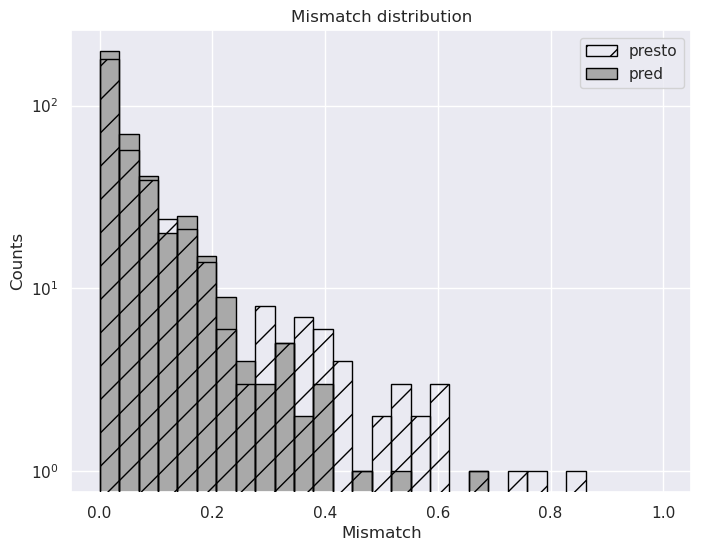

In [74]:
# Define the base color
base_color = 'skyblue'

# Adjust the darkness level
darker_level = 0.8  # Adjust the value between 0 and 1 for different darkness levels

# Create darker shade of skyblue
darker_skyblue = mcolors.to_rgb(base_color)
darker_skyblue = [x * darker_level for x in darker_skyblue]

a = 'fold_snr_true'
b = 'fold_snr_theory'
mismatch_true = 1-(labels_df_filtered[a]/labels_df_filtered[b])
a = 'fold_snr_presto'
b = 'fold_snr_theory'
mismatch_presto = 1-(labels_df_filtered[a]/labels_df_filtered[b])
a = 'fold_snr_pred'
b = 'fold_snr_theory'
mismatch_pred = 1-(labels_df_filtered[a]/labels_df_filtered[b])
bin_edges = np.linspace(0,1,30)
fig,ax = plt.subplots(figsize=(8,6))
# ax1 = ax.twiny()
accel_diff = np.abs(labels_df_filtered['a'].abs() - labels_df_filtered['a_max'])
ax.set_xlabel('Mismatch')
ax.set_yscale('log')
darker_grey = '0.6'
#ax.hist(mismatch_true,bins=bin_edges,alpha=1,label='true',color=darker_grey,edgecolor='black')
ax.hist(mismatch_presto,bins=bin_edges,fill = False,hatch='/',label='presto',alpha=1,edgecolor='black',zorder=100)
ax.hist(mismatch_pred,bins=bin_edges,color='darkgrey',label='pred',alpha=1,edgecolor='black')
#ax.hist(accel_diff/np.max(accel_diff),alpha=0.4,color='skyblue',bins=bin_edges,label='Relative\ndeviation\nfrom max\nacceleration',zorder=0)

#make x axis log
# ax1.set_yscale('log')
# # no ticks on x axis
# ax1.set_xticks([])

# Set the color of the x-axis ticks
#ax1.tick_params(axis='x', colors=darker_skyblue)
#ax1.set_xlabel('Relative deviation from max acceleration',labelpad=-10,color=darker_skyblue)
ax.set_ylabel('Counts')
# ax.arrow(0.03, 230, 0.9, 0, color='darkgrey', width=2,
#          head_width=20, head_length=0.03, length_includes_head=True)
# ax.text(0, 210, '0', fontsize=12, ha='center', va='bottom',
#         color='black',zorder=200)
# ax.text(1, 210, '1', fontsize=12, ha='center', va='bottom',
#         color='black',zorder=200)
# Create a solid bar outside the plot
plt.legend()
ax.set_title('Mismatch distribution')
plt.savefig('plots/mismatch_hist_true_n_pred.png',dpi=300,bbox_inches='tight')


In [2]:
uni_files = glob.glob('meta_data/uniformZv3/output.uni*')

In [3]:
for file in uni_files:
    pd.read_csv

In [4]:
import csv
data = []
for file in uni_files:
    with open(file, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        next(reader)  # Skip the header row
        for row in reader:
            data.append(row)

In [34]:
# set columns
labels_df = labels_df[~labels_df['e'].isna()]

In [35]:
labels_df.to_csv('meta_data/labels_runBE.csv',index=False)

In [20]:
labels_df = labels_df.astype(float)

(array([6832., 7616., 6524., 6916., 6832., 8372., 7644., 7196., 7532.,
        7336., 7056., 6944., 6300., 7252., 6720., 6496., 7392., 7308.,
        7168., 7196., 7840., 7140., 7336., 8036., 6832., 6356., 7000.,
        6552., 6496., 7644., 7000., 7448., 6496., 7252., 7000., 7644.,
        6776., 7504., 7336., 7308., 7000., 7644., 6496., 7000., 6944.,
        7560., 7560., 8316., 7672., 7336., 6496., 7028., 6636., 7420.,
        6776., 7616., 7896., 7476., 7336., 6552., 7028., 7700., 7280.,
        7000., 7728., 7476., 7140., 7896., 6664., 6832., 7504., 7196.,
        7252., 7112., 7420., 6440., 6580., 7140., 7616., 7672., 6356.,
        7112., 7196., 7168., 6804., 7728., 6664., 7252., 7224., 7308.,
        8036., 7140., 7000., 7840., 7140., 7224., 8064., 7840., 7868.,
        7504.]),
 array([2.29818262e-06, 1.00020678e-02, 2.00018374e-02, 3.00016071e-02,
        4.00013767e-02, 5.00011463e-02, 6.00009160e-02, 7.00006856e-02,
        8.00004552e-02, 9.00002249e-02, 9.99999945e-02, 1.

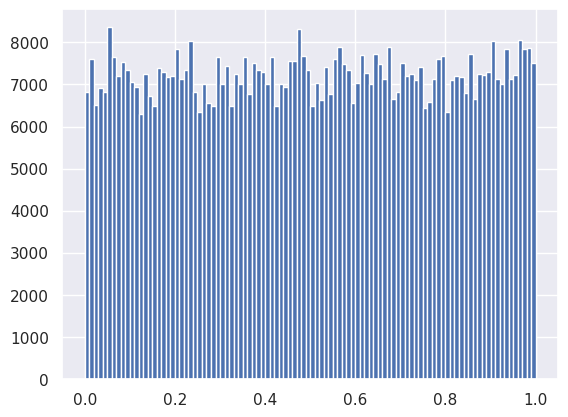

In [31]:
plt.hist(labels_df['lp'].values,bins=100)

In [11]:
labels_df.columns = ['ind','period','snr','width','bper','binc','bcmass','bphase','z','e','lp']